In [18]:
# Load the necessary packages
import json, re, networkx as nx, numpy as np, os, sys, nltk, matplotlib.pyplot as plt, pandas as pd, wordcloud
from tqdm import tqdm_notebook
from scipy.stats import spearmanr
from os import path
from PIL import Image

# Sentiment Analysis of the different pokemon types 

In [19]:
# Load the pokemon dataframe

poke_df = pd.read_csv('pokemon_data.csv')
poke_df.head()

Pokémon  Sentiment  Sentiment_stemmed                  Type  HP  Attack  \
0    Voltorb   5.878889           5.902800              Electric  40      30   
1  Electrode   5.716471           5.585263              Electric  60      50   
2  Exeggcute   5.632933           5.577097  ('Grass', 'Psychic')  60      40   
3  Exeggutor   5.623797           5.670000  ('Grass', 'Psychic')  95      95   
4     Cubone   5.261880           5.271667                Ground  50      50   

   Defense  SpAtk  SpDef  Speed  Total Generation Legendary  \
0       50     55     55    100    330          I      None   
1       70     80     80    140    480          I      None   
2       80     60     45     40    325          I      None   
3       85    125     65     55    520          I      None   
4       95     40     50     35    320          I      None   

                                              Tokens  \
0  ['voltorb', 'spherical', 'pokémon', 'resembles...   
1  ['electrode', 'round', 'pokémon', 'resembling'...   
2  ['exeggcute', 'pokémon', 'resembling', 'six', ...   
3  ['exeggutor', 'tall', 'bipedal', 'pokémon', 'r...   
4  ['cubone', 'small', 'bipedal', 'pokémon', 'lig...   

                                      Tokens_stemmed  
0  ['voltorb', 'spheric', 'pokémon', 'resembl', '...  
1  ['electrod', 'round', 'pokémon', 'resembl', 'r...  
2  ['exeggcut', 'pokémon', 'resembl', 'six', 'lig...  
3  ['exeggutor', 'tall', 'biped', 'pokémon', 'res...  
4  ['cubon', 'small', 'biped', 'pokémon', 'light'...

In [20]:
# Get all the found pokemon types
poke_types = poke_df.Type.unique()
corr_dict = {}
corr_dict_stemmed = {}
for poke_type in tqdm_notebook(poke_types):
    # First get the pokemons with the specific type
    pokemons_by_type = poke_df[poke_df['Type'] == poke_type]
    
    # Get their sentiment values and their total stats
    pokemons_by_type_sentiment_stemmed = pokemons_by_type['Sentiment_stemmed']
    pokemons_by_type_sentiment = pokemons_by_type['Sentiment']
    pokemons_by_type_total = pokemons_by_type['Total']
    
    # Check correlation between biology text sentiment and total stats and store it
    corr_coef_stemmed = spearmanr(pokemons_by_type_sentiment_stemmed, pokemons_by_type_total)[0]
    corr_coef = spearmanr(pokemons_by_type_sentiment, pokemons_by_type_total)[0]
    
    # Only check for correlation if more than 5 pokemons of this type exists
    if len(pokemons_by_type) >= 5:
        corr_dict[poke_type] = corr_coef
        corr_dict_stemmed[poke_type] = corr_coef_stemmed
        
    
    

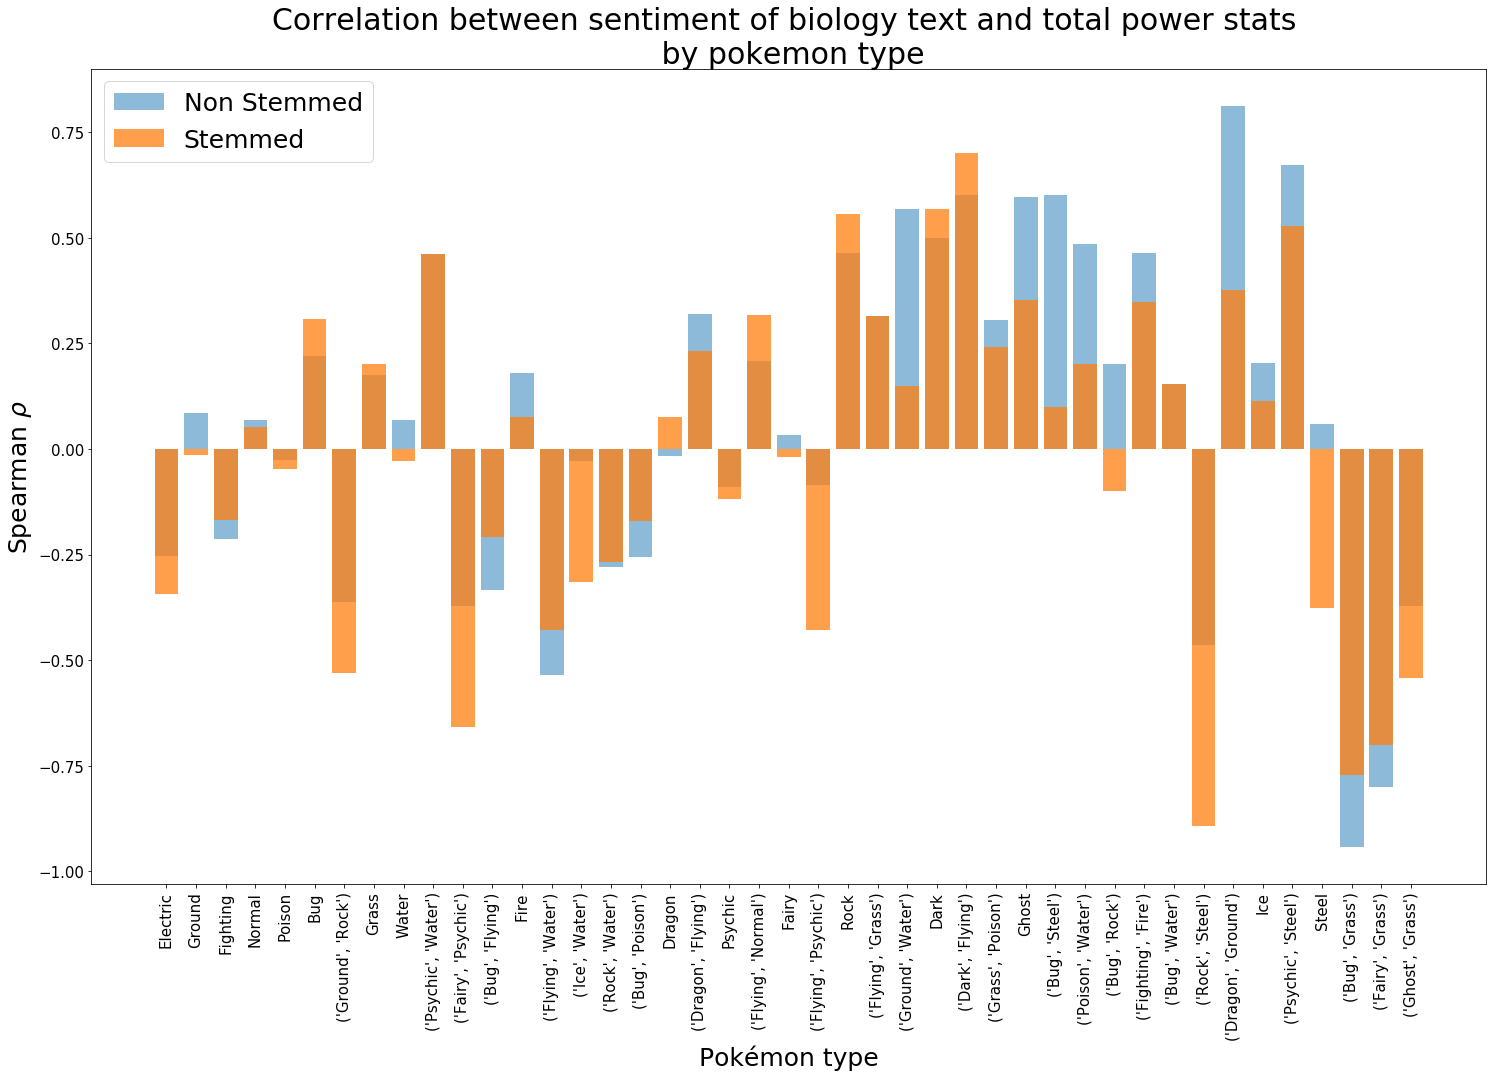

In [21]:
# Plot the results for both the stemmed and non stemmed versions
plt.figure(figsize=(25,15))
plt.bar((corr_dict.keys()), (corr_dict.values()), label = 'Non Stemmed', alpha = .5)
plt.bar((corr_dict_stemmed.keys()), (corr_dict_stemmed.values()), label = 'Stemmed', alpha = .75)
plt.xticks(rotation='vertical', size=15)
plt.yticks(size=15)
plt.title('Correlation between sentiment of biology text and total power stats \n by pokemon type', fontsize = 30)
plt.ylabel(r'Spearman $\rho$', fontsize = 25)
plt.xlabel('Pokémon type', fontsize = 25)
plt.legend(fontsize = 25)
plt.show()

In [25]:
# Used to generate the word clouds for each type
single_types = sorted(poke_df.Type.unique())[119:]
single_types

['Bug',
 'Dark',
 'Dragon',
 'Electric',
 'Fairy',
 'Fighting',
 'Fire',
 'Flying',
 'Ghost',
 'Grass',
 'Ground',
 'Ice',
 'Normal',
 'Poison',
 'Psychic',
 'Rock',
 'Steel',
 'Water']

In [ ]:
type_tokens = {}
type_corpus = {}
# Loop through all the single types
for types in single_types:
    type_tokens[types] = ""
    # Get all the tokens for that specific type
    tokens = poke_df.Tokens[poke_df.Type == types]    
    type_corpus[types] = []
    # Join all the tokens in a large string and store it in a dictionary indexed by type as key
    for token in tokens:
        type_corpus[types].extend(eval(token))
        type_tokens[types] += " ".join(eval(token))
        type_tokens[types] += " "

In [39]:
def augmented_Frequency(FreqDist):
    aug_tf = []
    tf = []
    total_words = len(FreqDist)
    max_freq = FreqDist.most_common(1)[0][1]
    total_freqs = sum(FreqDist.values())
    # This way we will start with the most frequent appearing word and adjusting for it 
    for word, freq in FreqDist.most_common(total_words):
        aug_tf_val = 0.5 + 0.5 * (freq/max_freq)
        aug_tf.append((word, aug_tf_val, freq))
        tf.append((word, freq/total_freqs, freq))
    
    return aug_tf, tf

In [86]:
from nltk import FreqDist
tf_types = {}
tf_idf_types = {}

number_corp = len(single_types)
for types in single_types:
    tf_types[types] = augmented_Frequency(FreqDist(type_corpus[types]))

for types in tqdm_notebook(single_types):
    aug_tf = tf_types[types][0]
    tf_idf_types[types] = []
    for word, tf, freq in aug_tf:
        word_count_corpus = 0
        for single_type in single_types:
            tmp_corpus = tf_types[single_type][0]
            for word_other, _, _ in tmp_corpus:
                if word == word_other:
                    word_count_corpus += 1
                    break
        idf_val = np.log(number_corp/word_count_corpus)
        tf_idf_types[types].append((word, tf, idf_val, tf*idf_val, freq))
        

#for freq_dist in freq_dists:
#    current_corpus = freq_dists[freq_dist]
    

In [109]:
tf_idf_strings = {}
for key in tf_idf_types:S
    tf_idf_strings[key] = ""
    for word, _, _, tf_idf, _ in tf_idf_types[key]:
        tf_idf_strings[key] += " ".join([int(np.ceil(tf_idf)) * f'{word} '])

In [111]:
wordclouds = {}
for types in tqdm_notebook(type_tokens):
    wordclouds[types] = wordcloud.WordCloud(stopwords=['pokémon','two','three','like']
                        , collocations=False, background_color='white', width = 800, height = 500).generate(tf_idf_strings[types])

In [117]:
path = "C:/Users/Bruger/Desktop/"
for wcs in wordclouds:
    wordclouds[wcs].to_file(path + f'{wcs}_wordcloud'+'.png')